# Compare 1 GY resampled daily QR (API) to weekly BLoomberg (excel)
100 stocks, from 2021-12-01 to 2021-01-31, loaded on 2024-09-05
* Excel weekly data (only friday): *QUANT_work..FUNDAMENTAL_DATA_STOCK_weekly_excel_test_100_stocks_v1*
* Excel daily data (weekends included): *QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_excel_test_100_stocks_v1*
* API daily data (NO weekend): *QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks_v1*

**Method resampling (weekly) of Bloomberg:**
* Weekly data (on Friday) of Bloomberg: last available value of the week (Monday to Sunday) will be assigned to be value of the week (noted friday) ***despite weekend***. *This is the principal difference with  QR method*

**Method of QR:**
* **Friday resample**
    * Reindex business daily data to full daily (including weekend)
    * Forwarfill with limit = 6 (week fill)
    * Keep only *Friday*

In this notebook, we identify 3 types of mismatch:

Parmi 5858 observations
* Type 1: BBG not NA, KC not NA, value different (differece >1%)): 0 observation (0%)
* Type 2: BBG not NA, KC NA: 172 observations (3%)
* Type 3: BBG NA, KC not NA: 76 observations (1.3%)

**Conclusion:**
* **we validate friday resample**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from dbtools.src.db_connexion import SqlConnector
import dbtools.src.get_repository as rep
from copy import deepcopy
import dbtools.src.dbtools_util as du
import matplotlib.pyplot as plt
import warnings
from pandas.tseries.offsets import BDay
pd.set_option('expand_frame_repr', False)

warnings.filterwarnings("ignore")
connector = SqlConnector()
con_mis = connector.connection()

In [3]:
FIELD = "eps_1gy"

In [4]:
## Load data
# daily of API
df_data_dict = pd.read_sql("""select attribute_id, name
                               from QUANT_work..FUNDAMENTAL_DATA_DICTIONARY""", con_mis)
df_data_dict = df_data_dict.set_index('attribute_id')['name']
df_daily_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks_v1', con_mis)
df_daily_db.DATE = pd.to_datetime(df_daily_db.DATE)
df_daily_db.attribute_id = df_daily_db.attribute_id.replace(df_data_dict)
df_daily_db = df_daily_db[df_daily_db.attribute_id==FIELD]

sec_common = df_daily_db.security_id.drop_duplicates()
dates = pd.date_range(df_daily_db.DATE.min(),df_daily_db.DATE.max())

df_daily_ts = df_daily_db.set_index(['DATE', 'security_id']).value.unstack()
df_daily_ts = df_daily_ts.reindex(index = dates, columns = sec_common)

## weekly from Excel
df_excel_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_weekly_excel_test_100_stocks_v1', con_mis)
df_excel_db.DATE = pd.to_datetime(df_excel_db.DATE)
df_excel_db.attribute_id = df_excel_db.attribute_id.replace(df_data_dict)
df_excel_db = df_excel_db[df_excel_db.attribute_id==FIELD]


df_excel_ts = df_excel_db.set_index(['DATE', 'security_id']).value.unstack()
df_excel_ts = df_excel_ts.reindex(columns = sec_common)
df_excel_ts = df_excel_ts[(df_excel_ts.index.weekday==4) & (df_excel_ts.index>df_excel_ts.index.min())]

In [5]:
ticker = rep.mapping_from_security(sec_common, 'fund_ticker')
ticker = ticker.to_frame('fund_ticker')
ticker['td_id'] = rep.mapping_from_security(sec_common, 'prim_td_id')
## security_id dont l'année fiscale ne change pas en 01 janvier
sec_anom = [258, 11963, 15210, 15726, 17821, 18590, 18678, 38718, 38763, 47044, 1037829, 2632714, 2752161, 2757656, 2764531, 2907194, 2925627]
sec_anom = pd.Index(sec_anom)

## Comparison 1GY

In [6]:
## Sampling (weekly example)
# reindex daily
# week fill (with limit = 6 jours)
# Resample weekly (friday)
filled_df = du.fill_week_with_nans(df_daily_db, date_column='DATE')
df_ffill = du.custom_forward_fill(filled_df, date_column='DATE', field=FIELD, group_by_columns=['attribute_id','security_id'])
resampled_df_fridays = du.resample_data(df_ffill, date_column='DATE', mode='weekly', calendar_type='friday')
df_res_fri = resampled_df_fridays.set_index(['DATE', 'security_id']).value.unstack()
df_res_fri = df_res_fri[(df_res_fri.index>=df_excel_ts.index.min()) & (df_res_fri.index<=df_excel_ts.index.max())]

In [7]:
### Fonction  detail_diff: security_id, date, 
# output: dict security_id, date, value Bloom weekly, value resample KC, last value daily, last value daily date, nb days fill, last value week date
def detail_diff(df_diff, df_daily):
    df_tmp = df_diff.copy()
    df_tmp = df_tmp.rename(columns = {'excel':'BBG weekly',
                            'resampled':'resample KC'})
    df_tmp = df_tmp.reindex(columns = ['BBG weekly', 'resample KC', 'diff',
                                        'prev. value daily', 'prev. daily date',
                                        'prev. weekday', 'nb days ffill',
                                      'next value daily', 'next daily date', 'nb days bfill',])
    for date, security_id in df_diff.index:
        iloc = df_daily[security_id].index.get_loc(date)
        s = df_daily.iloc[:iloc+1][security_id].dropna()
        n = df_daily.iloc[iloc:][security_id].dropna()
        if s.empty:
            s = df_daily.iloc[[iloc]][security_id]
        if n.empty:
            n = df_daily.iloc[[iloc]][security_id]
        df_tmp.loc[(date, security_id),'prev. value daily'] = s.iloc[-1]
        df_tmp.loc[(date, security_id),'prev. weekday'] = s.index[-1].day_name()
        df_tmp.loc[(date, security_id),'prev. daily date'] = s.index[-1].date()
        df_tmp.loc[(date, security_id),'nb days ffill'] = (pd.to_datetime(date)-s.index[-1]).days

        df_tmp.loc[(date, security_id),'next value daily'] = n.iloc[0]
        df_tmp.loc[(date, security_id),'next daily date'] = n.index[0].date()
        df_tmp.loc[(date, security_id),'nb days bfill'] = (pd.to_datetime(n.index[0].date())-s.index[-1]).days
    df_tmp['prev. daily date'] = pd.to_datetime(df_tmp['prev. daily date'])
    df_tmp['next daily date'] = pd.to_datetime(df_tmp['next daily date'])
    return df_tmp

### Comparison resampled friday vs bloom
Parmi 5858 observations
* Type 1: 0 observation
* Type 2: 172 obs (BBG a des valeurs, KC est NA)
* Type 3: 76 obs BBG est NA, KC a des valeurs

In [8]:
df_diff_fri = pd.concat((df_excel_ts.stack(), df_res_fri.stack()), axis =1)
df_diff_fri.columns = ['excel', 'resampled']
df_diff_fri['diff'] = (df_diff_fri.resampled - df_diff_fri.excel)/df_diff_fri.resampled
df_diff_fri = detail_diff(df_diff_fri, df_daily_ts)
df_diff_fri.head()

BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
DATE       security_id                                                                                                                                                 
2021-12-10 25                4.575        4.575   0.0              4.575       2021-12-10        Friday            0.0             4.575      2021-12-10            0.0
           31                2.716        2.716   0.0              2.716       2021-12-09      Thursday            1.0             2.716      2021-12-24           15.0
           210              25.437       25.437   0.0             25.437       2021-12-07       Tuesday            3.0            25.444      2021-12-13            6.0
           258               4.329        4.329   0.0              4.329       2021-12-08     Wednesday            2.0             4.339      2021-12-13            5.0
           286              -0.265       -0.265  -0.0             -0.265       2021-12-10        Friday            0.0            -0.265      2021-12-10            0.0

In [42]:
# df_daily_ts[[25,31]].loc['20211210':'20220110'].dropna(how = 'all')
# df_daily_ts[[25,31]].loc['20221225':'20230110'].dropna(how = 'all')
# df_daily_ts[[25,31]].loc['20231205':'20240110'].dropna(how = 'all')

In [50]:
# df_excel_ts[[25,31]].loc['20211210':'20220110'].dropna(how = 'all')
# df_excel_ts[[25,31]].loc['20221215':'20230130'].dropna(how = 'all')
# df_excel_ts[[25,31]].loc['20231205':'20240130'].dropna(how = 'all')

#### TYPE 1: absolute relative difference >1%
No observation

In [9]:
df_type1 = df_diff_fri[df_diff_fri['diff'].abs()>0.01].sort_values(by = ['security_id', 'DATE'])
df_type1

Empty DataFrame
Columns: [BBG weekly, resample KC, diff, prev. value daily, prev. daily date, prev. weekday, nb days ffill, next value daily, next daily date, nb days bfill]
Index: []

#### TYPE 2, 3: Difference is NA
* TYPE 2: BBG dispo mais KC NA
* TYPE 3: BBG NA mais KC dispo

In [86]:
df_diff_na  = df_diff_fri[df_diff_fri['diff'].isna() & (df_diff_fri['resample KC']!=0)].sort_values(by = ['security_id', 'DATE'])
df_diff_na = df_diff_na.reset_index()
df_diff_na.DATE = df_diff_na.DATE.dt.strftime('%Y.%m.%d')
df_type2 = df_diff_na[df_diff_na['resample KC'].isna()]
df_type3 = df_diff_na[df_diff_na['resample KC'].notna()]

df_type2['forwardfill'] = df_type2['BBG weekly']==df_type2['prev. value daily']
df_type2['backfill'] = (df_type2['BBG weekly']==df_type2['next value daily']) & (df_type2['BBG weekly']!=df_type2['prev. value daily'])
df_type2['interpolation'] = (df_type2['BBG weekly']!=df_type2['next value daily'])& (df_type2['BBG weekly']!=df_type2['prev. value daily'])

In [117]:
count_date = pd.concat((df_diff_na[['DATE']], df_diff_na[['BBG weekly', 'resample KC']].isna()), axis = 1).groupby('DATE').sum()
count_date['total'] = count_date[['BBG weekly', 'resample KC']].sum(axis =1)
count_date = count_date.sort_values('total')
count_date = count_date.rename(columns = {'BBG weekly': 'Type 3', 'resample KC':'Type 2'})

count_type2 = df_type2[['DATE','forwardfill', 'backfill', 'interpolation']].groupby('DATE').sum()
count_type2['total'] = count_type2[['forwardfill', 'backfill', 'interpolation']].sum(axis =1)
count_type2 = count_type2.sort_values('total')

count_sec = pd.concat((df_diff_na[['security_id']], df_diff_na[['BBG weekly', 'resample KC']].isna()), axis = 1).groupby('security_id').sum()
count_sec['total'] = count_sec[['BBG weekly', 'resample KC']].sum(axis =1)
count_sec = count_sec.sort_values('total')
count_sec = count_sec.rename(index =ticker.fund_ticker, columns = {'BBG weekly': 'Type 3', 'resample KC':'Type 2'})

In [118]:
print('---- Error type 2: -------\n', count_type2.sum())
print('---- Error type 3: ------', df_type3.shape[0])

---- Error type 2: -------
 forwardfill       26
backfill         136
interpolation     10
total            172
dtype: int64
---- Error type 3: ------ 76


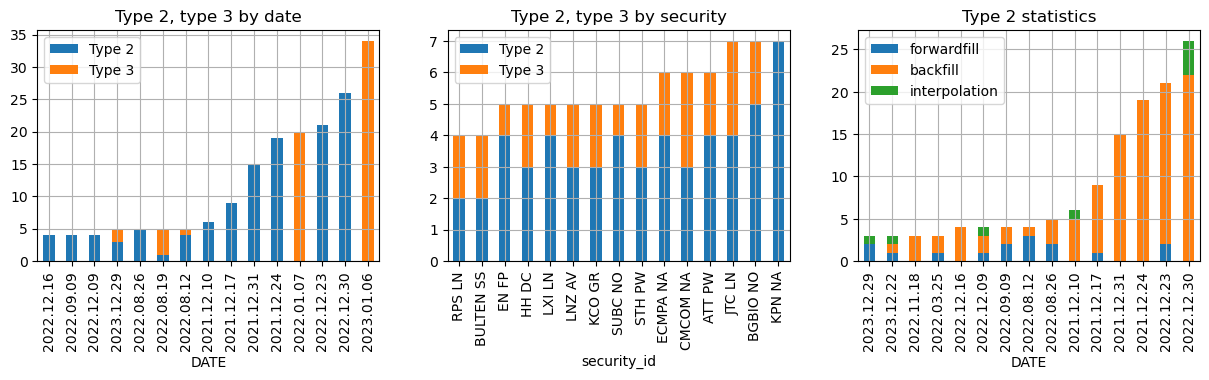

In [165]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
a = count_date.iloc[-15:][['Type 2', 'Type 3']]
a.plot.bar(stacked = True, ax=ax[0], title = 'Type 2, type 3 by date')

b = count_sec.iloc[-15:][['Type 2', 'Type 3']]
b.plot.bar(stacked = True, ax = ax[1], title = 'Type 2, type 3 by security')

c = count_type2.iloc[-15:][['forwardfill', 'backfill', 'interpolation']]
c.plot.bar(stacked = True, ax=ax[2], title = 'Type 2 statistics')
[ax[i].grid() for i in range(len(ax))]
plt.show()
df_type2 = df_type2.drop(columns = ['forwardfill', 'backfill', 'interpolation'])

##### Type 2; KC NA, BBG available

In [166]:
print("On a l'impression que Bloomberg utilise forward fill (> 1 semaine)")
df_type2[df_type2['BBG weekly']==df_type2['prev. value daily']]

On a l'impression que Bloomberg utilise forward fill (> 1 semaine)


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
5    2022.08.12           31       2.623          NaN   NaN              2.623       2022-08-05        Friday            7.0             2.623      2022-08-15           10.0
7    2023.08.18           31       3.068          NaN   NaN              3.068       2023-08-11        Friday            7.0             3.068      2023-08-28           17.0
10   2022.09.09           89      35.860          NaN   NaN             35.860       2022-09-01      Thursday            8.0            35.860      2022-09-12           11.0
13   2022.08.12          286      -0.110          NaN   NaN             -0.110       2022-08-04      Thursday            8.0            -0.110      2022-08-15           11.0
31   2022.12.09         8087       1.020          NaN   NaN              1.020       2022-12-01      Thursday            8.0             1.020      2022-12-12           11.0
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
154  2022.08.26      1298078       0.400          NaN   NaN              0.400       2022-08-15        Monday           11.0             0.400      2022-08-29           14.0
184  2023.11.24      2764505      -2.442          NaN   NaN             -2.442       2023-11-13        Monday           11.0            -1.904      2024-01-01           49.0
199  2023.02.24      2783174       0.760          NaN   NaN              0.760       2023-02-14       Tuesday           10.0             0.615      2023-02-27           13.0
217  2021.12.17      2907194      -0.014          NaN   NaN             -0.014       2021-12-10        Friday            7.0            -0.014      2022-01-03           24.0
218  2022.04.22      2907194       0.046          NaN   NaN              0.046       2022-04-11        Monday           11.0             0.046      2022-05-02           21.0

[26 rows x 12 columns]

In [167]:
print("On a l'impression que Bloomberg utilise backfill")
df_type22 = df_type2[(df_type2['BBG weekly']==df_type2['next value daily']) & (df_type2['BBG weekly']!=df_type2['prev. value daily'])]
df_type22

On a l'impression que Bloomberg utilise backfill


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
0    2021.12.17           25       4.803          NaN   NaN              4.575       2021-12-10        Friday            7.0             4.803      2022-01-03           24.0
1    2022.08.26           25       4.892          NaN   NaN              4.869       2022-08-15        Monday           11.0             4.892      2022-09-12           28.0
2    2022.09.02           25       4.892          NaN   NaN              4.869       2022-08-15        Monday           18.0             4.892      2022-09-12           28.0
4    2021.12.31           31       2.773          NaN   NaN              2.716       2021-12-24        Friday            7.0             2.773      2022-01-03           10.0
9    2021.12.31           89      20.038          NaN   NaN             16.203       2021-12-21       Tuesday           10.0            20.038      2022-01-03           13.0
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
240  2021.12.24      3031213       0.545          NaN   NaN              0.178       2021-12-14       Tuesday           10.0             0.545      2022-01-03           20.0
241  2022.12.30     10172537       3.077          NaN   NaN              2.633       2022-12-22      Thursday            8.0             3.077      2023-01-02           11.0
243  2022.07.29     10173378       1.113          NaN   NaN              1.140       2022-07-21      Thursday            8.0             1.113      2022-08-08           18.0
245  2022.11.18     10173378       1.120          NaN   NaN              1.023       2022-11-11        Friday            7.0             1.120      2022-11-21           10.0
246  2022.12.23     10173378       1.328          NaN   NaN              1.152       2022-12-13       Tuesday           10.0             1.328      2023-01-02           20.0

[136 rows x 12 columns]

In [168]:
print("Pour les backfill, souvent BBG utilise la valeur de la prochaine année fiscale pour filler la fin le l'année précécente, on voit bien le saut (pct_jump)")
df_bffill = df_type22[(df_type22['next daily date'].isin(['2024-01-01', '2023-01-02', '2022-01-03'])) & (df_type22.DATE.str[5:7]=='12')]
df_bffill['pct_jump'] = ((df_bffill['BBG weekly'] - df_bffill['prev. value daily'])/df_bffill['prev. value daily']*100).round(2)
df_bffill.sort_values(by = ['security_id', 'next daily date'])

Pour les backfill, souvent BBG utilise la valeur de la prochaine année fiscale pour filler la fin le l'année précécente, on voit bien le saut (pct_jump)


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill  pct_jump
0    2021.12.17           25       4.803          NaN   NaN              4.575       2021-12-10        Friday            7.0             4.803      2022-01-03           24.0      4.98
4    2021.12.31           31       2.773          NaN   NaN              2.716       2021-12-24        Friday            7.0             2.773      2022-01-03           10.0      2.10
9    2021.12.31           89      20.038          NaN   NaN             16.203       2021-12-21       Tuesday           10.0            20.038      2022-01-03           13.0     23.67
12   2021.12.31          286       0.512          NaN   NaN             -0.265       2021-12-24        Friday            7.0             0.512      2022-01-03           10.0   -293.21
15   2022.12.23          286       2.071          NaN   NaN             -0.304       2022-12-12        Monday           11.0             2.071      2023-01-02           21.0   -781.25
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...       ...
236  2021.12.17      3018908       2.420          NaN   NaN              2.110       2021-12-09      Thursday            8.0             2.420      2022-01-03           25.0     14.69
238  2022.12.23      3018908       0.695          NaN   NaN              1.545       2022-12-13       Tuesday           10.0             0.695      2023-01-02           20.0    -55.02
240  2021.12.24      3031213       0.545          NaN   NaN              0.178       2021-12-14       Tuesday           10.0             0.545      2022-01-03           20.0    206.18
241  2022.12.30     10172537       3.077          NaN   NaN              2.633       2022-12-22      Thursday            8.0             3.077      2023-01-02           11.0     16.86
246  2022.12.23     10173378       1.328          NaN   NaN              1.152       2022-12-13       Tuesday           10.0             1.328      2023-01-02           20.0     15.28

[96 rows x 13 columns]

In [169]:
print("On a l'impression que Bloomberg utilise interpolation par les valeur avant et après. Il y a bcp de valeur de fin d'année")
df_type2[(df_type2['BBG weekly']!=df_type2['next value daily'])& (df_type2['BBG weekly']!=df_type2['prev. value daily'])]

On a l'impression que Bloomberg utilise interpolation par les valeur avant et après. Il y a bcp de valeur de fin d'année


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
6    2022.10.28           31       2.572          NaN   NaN              2.577       2022-10-20      Thursday            8.0             2.550      2022-10-31           11.0
11   2022.12.30          210      33.741          NaN   NaN             32.236       2022-12-23        Friday            7.0            33.729      2023-01-02           10.0
22   2022.12.30         6254       0.673          NaN   NaN              0.555       2022-12-20       Tuesday           10.0             0.681      2023-01-02           13.0
45   2022.12.30        12057       0.236          NaN   NaN              0.194       2022-12-19        Monday           11.0             0.233      2023-01-02           14.0
71   2023.12.22        19072       0.252          NaN   NaN              0.256       2023-12-12       Tuesday           10.0             0.891      2024-01-01           20.0
72   2023.12.29        19072       0.257          NaN   NaN              0.256       2023-12-12       Tuesday           17.0             0.891      2024-01-01           20.0
133  2022.12.30       395770       5.454          NaN   NaN              4.670       2022-12-19        Monday           11.0             5.432      2023-01-02           14.0
162  2021.12.10      2732114       0.198          NaN   NaN              0.142       2021-12-03        Friday            7.0             0.175      2022-01-03           31.0
194  2022.12.09      2765679      -3.371          NaN   NaN             -3.467       2022-11-28        Monday           11.0            -3.628      2023-01-02           35.0
210  2023.12.08      2833331       6.032          NaN   NaN              4.473       2023-12-01        Friday            7.0             7.148      2023-12-11           10.0

##### Type 3: BBG NA, KC available

In [15]:
df_type3

DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
3    2022.09.16           25         NaN        4.892   NaN              4.892       2022-09-12        Monday            4.0             4.904      2022-09-19            7.0
8    2023.09.01           31         NaN        3.068   NaN              3.068       2023-08-28        Monday            4.0             3.068      2023-09-07           10.0
14   2022.08.19          286         NaN       -0.110   NaN             -0.110       2022-08-15        Monday            4.0            -0.110      2022-08-23            8.0
19   2023.01.06          436         NaN        0.893   NaN              0.893       2023-01-02        Monday            4.0             0.898      2023-02-02           31.0
28   2023.01.06         6672         NaN        4.288   NaN              4.288       2023-01-02        Monday            4.0             4.196      2023-01-09            7.0
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
237  2022.01.07      3018908         NaN        2.420   NaN              2.420       2022-01-03        Monday            4.0             2.460      2022-03-16           72.0
239  2023.01.06      3018908         NaN        0.695   NaN              0.695       2023-01-02        Monday            4.0             0.663      2023-03-16           73.0
242  2023.01.06     10172537         NaN        3.077   NaN              3.077       2023-01-02        Monday            4.0             3.230      2023-02-03           32.0
244  2022.08.12     10173378         NaN        1.113   NaN              1.113       2022-08-08        Monday            4.0             1.188      2022-08-15            7.0
247  2023.01.06     10173378         NaN        1.328   NaN              1.328       2023-01-02        Monday            4.0             1.210      2023-02-17           46.0

[76 rows x 12 columns]

# End of notebook

#### stocks dont 1GY sont dispo le 1er janvier, début l'année fiscale, même si un weekend
Tous les stocks dont l'année fiscale commence en janvier ont des données 1GY

In [16]:
df_fy_23 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20221228', '20230105'))]
df_fy_23 = df_fy_23.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

df_fy_22 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20211228', '20220105'))]
df_fy_22 = df_fy_22.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

In [17]:
df_fy_23[df_fy_23['2023-01-01'].isna()]

KeyError: '2023-01-01'

In [ ]:
df_fy_22[df_fy_22['2022-01-01'].isna()]

#### Si les données de 1GY début l'AF est remplies par 2GY de l'année précédente: NON

In [ ]:
df = pd.concat((df_1gy_daily_ts.loc['2023-01-01'].to_frame('1GY_20230101'),
                df_2gy_daily_ts.loc['2022-01-01'].to_frame('2GY_20220101')), axis = 1)
df = df[~df.index.isin(sec_anom)]
df['is_filled'] = df['1GY_20230101'] == df['2GY_20220101']
df[df.is_filled]